In [1]:
import pandas as pd
import numpy as np
import string
import re
import time

import matplotlib.pyplot as plt


import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score,precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE 



In [2]:
# Read file
filename = '../data/judge-1377884607_tweet_product_company.csv'

sentiments_df = pd.read_csv("Data/tweets.csv", encoding = 'iso-8859-1')


In [3]:
# Data overview
sentiments_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
# Randomly check tweet text for a couple of rows

pd.set_option('display.max_colwidth', None)
indexes = np.random.randint(0,len(sentiments_df),6)
sentiments_df['tweet_text'].loc[indexes]


759                                                                  Google to Launch Major New Social Network Called Circles {link} #sxsw
1440            Good Work! ÛÏ@mention @mention Check the latest stream at Apple's store at #SXSW {link} . ipad2 here I come. #PLAYSXSWÛ
3418           @mention has evolved from novelty game to essential utility. What now @mention @mention {link} via @mention @IndySaha #sxsw
6858                                                     RT @mention w00t! @mention wrote about our #hollergram iPad app for #sxsw! {link}
2809    Help me decide which panel to go to next: Future of Social Photography or Google Doodles: Burning Man to Pac-Man and Beyond. #sxsw
4511                         Google finding new ways to help small business say more on their Place Page #sxsw [Here's our overview {link}
Name: tweet_text, dtype: object

In [5]:
# Check number of records, data types and which columns have nan

sentiments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
# Check values for column 'emotion_in_tweet_is_directed_at'

sentiments_df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [7]:
# Confirm number of NaN in column 'emotion_in_tweet_is_directed_at'

sentiments_df['emotion_in_tweet_is_directed_at'].isna().sum()

5802

In [8]:
# Check values for column 'is_there_an_emotion_directed_at_a_brand_or_product'

sentiments_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [9]:
sentiments_df['tweet_text'] = sentiments_df['tweet_text'].astype('str') 

In [10]:
# Capital letter column function
def capital_letter_ratio(tweet):
    #Initialize count 
    capital_count = 0
    
    # Iterate through tweets for caps
    for c in tweet:
        if c.isupper():
            capital_count += 1
    return capital_count / len(tweet)

#Adds capital letter ratio column
sentiments_df['caps_ratio'] = sentiments_df['tweet_text'].apply(capital_letter_ratio)

In [11]:
# Exclamation column function
def exc_count(tweet):
    
    punctuation = '!'
    # Initialize count
    count = 0
    
    # Find punctuation
    for punc in punctuation:
        count += tweet.count(punc)
    return count

#Adds count column to the tweets
sentiments_df['!_count'] = sentiments_df['tweet_text'].apply(exc_count)

In [12]:
# Question mark column function
def que_count(tweet):
    
    punctuation = '?'
    # Initialize count
    count = 0
    
    # Find punctuation
    for punc in punctuation:
        count += tweet.count(punc)
    return count

#Adds count column to the tweets
sentiments_df['?_count'] = sentiments_df['tweet_text'].apply(que_count)

In [13]:
sentiments_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,caps_ratio,!_count,?_count
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion,0.118110,1,0
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion,0.071942,0,1
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,0.088608,0,0
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,0.024390,0,0
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,0.106870,0,0


In [14]:

def find_company_name_v2(text,emotion_at):
    
    '''
    Go through text ('tweet_text' column) and determine whether it is about apple or google and
    return either 'apple' or 'google' according to search.
    If cannot tell company id from text, check emotion_at ('emotion_in_tweet_is_directed_at'
    column) for comapy id. If cannot find company id return 'cannot tell'.
    '''
    
    revised_emotion_at = str(emotion_at).lower()
    
    
    revised_text = str(text).lower()
    
    apple = ['apple','iphone','ipad']
    google = ['google','android']
    
    apple_count = 0
    google_count = 0
    
    for a in apple:
        apple_count += sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(a), revised_text))
        
    for g in google:
        google_count += sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(g), revised_text))
    

    if apple_count > google_count:
        return 'apple'
    elif google_count > apple_count:
        return 'google'
    elif revised_emotion_at != 'nan' and revised_emotion_at != 'default':
        for idx, item in enumerate(revised_emotion_at.split()):
            if item in apple:
                return 'apple'
            elif item in google:
                return 'google'
            else:
                if idx == len(revised_emotion_at.split()): 
                    return 'cannot tell'
    else:
        return 'cannot tell'

In [15]:
# Create a new column called 'company_name' and find whether the tweet is about apple,
# google or cannot tell using function find_company_name
 
sentiments_df['company_name'] = sentiments_df.apply(
    lambda s: find_company_name_v2(s['tweet_text'],s['emotion_in_tweet_is_directed_at']),axis=1) 

sentiments_df['company_name'].value_counts()


apple          5331
google         2814
cannot tell     948
Name: company_name, dtype: int64

In [16]:
# Tweets for which cannot tell whether comment directed to apple or google the
# sentiment is mostly neutral (over 95%)

cannot_tell = sentiments_df[sentiments_df['company_name'] == 'cannot tell']
cannot_tell['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    911
Positive emotion                       23
I can't tell                           10
Negative emotion                        4
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [17]:
# Drop any row where 'tweet_text' is nan
sentiments_df.drop(sentiments_df[sentiments_df['tweet_text'].isna()].index,inplace=True)

# Drop any row where 'is_there_an_emotion_directed_at_a_brand_or_product' says 'I can't tell'
column_name = 'is_there_an_emotion_directed_at_a_brand_or_product'
match = 'I can\'t tell'
sentiments_df.drop(sentiments_df[sentiments_df[column_name] == match].index, inplace=True)


# Drop any rows where column 'company_name' says 'cannot tell'
sentiments_df.drop(sentiments_df[sentiments_df['company_name'] == 'cannot tell'].index,
                  inplace=True)

sentiments_df['company_name'].value_counts()

apple     5236
google    2763
Name: company_name, dtype: int64

In [18]:
# Create a function that returns 0 for negative sentiment, 1 for neutral sentiment
# and 2 for positive sentiment

def convert_emotion_tonumber(emotion):
    if emotion == 'Negative emotion':
        return 0
    elif emotion == 'Positive emotion':
        return 2
    else:
        return 1  # for neutral emotion

In [19]:
# Create a column called 'sentiment' and pass value from 
# 'is_there_an_emotion_directed_at_a_brand_or_product' to function convert_emotion_tonumber.

sentiments_df['sentiment'] = sentiments_df[
    'is_there_an_emotion_directed_at_a_brand_or_product'].map(
    lambda s: convert_emotion_tonumber(s))

sentiments_df['sentiment'].value_counts()

1    4478
2    2955
0     566
Name: sentiment, dtype: int64

In [20]:
sentiments_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7999 entries, 0 to 9092
Data columns (total 8 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   tweet_text                                          7999 non-null   object 
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object 
 2   is_there_an_emotion_directed_at_a_brand_or_product  7999 non-null   object 
 3   caps_ratio                                          7999 non-null   float64
 4   !_count                                             7999 non-null   int64  
 5   ?_count                                             7999 non-null   int64  
 6   company_name                                        7999 non-null   object 
 7   sentiment                                           7999 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 562.4+ KB


In [21]:
# Create an intermediate dataframe that only contains columns 'tweet_text','company_name'
# sentiment

sentiments2_df = sentiments_df[['tweet_text','company_name','sentiment', 'caps_ratio', '!_count', '?_count']].copy()


In [22]:
sentiments2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7999 entries, 0 to 9092
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tweet_text    7999 non-null   object 
 1   company_name  7999 non-null   object 
 2   sentiment     7999 non-null   int64  
 3   caps_ratio    7999 non-null   float64
 4   !_count       7999 non-null   int64  
 5   ?_count       7999 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 437.4+ KB


In [23]:
# Split sentiments2_df into two data frames where apple_df contains all tweets about apple
# google_df contains all tweets about google

apple_df = sentiments2_df[sentiments2_df['company_name'] == 'apple'].copy()
google_df = sentiments2_df[sentiments2_df['company_name'] == 'google'].copy()


In [54]:
apple_X = apple_df[['tweet_text', 'caps_ratio', '!_count', '?_count']]
google_X = google_df[['tweet_text', 'caps_ratio', '!_count', '?_count']]

In [55]:
# Split apple_df and google_df into train and test samples using train_test_split

X_train_app, X_test_app, y_train_app, y_test_app = train_test_split(apple_X,
                                                apple_df['sentiment'],test_size = 0.4, 
                                                stratify = apple_df['sentiment'],
                                                random_state = 6781)

X_train_goo, X_test_goo, y_train_goo, y_test_goo = train_test_split(google_X,
                                                google_df['sentiment'],test_size = 0.4, 
                                                stratify = google_df['sentiment'],
                                                random_state = 6782)


In [56]:
a = len(X_train_app)
g = len(X_train_goo)
a+g

4798

In [57]:
def get_wordnet_pos(tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [58]:
def nlp_doc_preparer(doc):
    '''
     - Customize nltk stop_words to include all punction marks
     - Split text into words containing letters
     - Make all letters lower case
     - Use pos_tag to mark up the words for a particular part of a speech
     - Use get_wordnet_pos to convert pos_tag to wordnet_pos
     - Convert word to root word with WordNetLemmatizer
     - Return processed document as a string of words
    '''
    
    custom_sw = stopwords.words('english')
    custom_sw.extend(list(string.punctuation))

    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in custom_sw]
    
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    
    return ' '.join(doc)


In [59]:
# Combined X_train_app and X_train_goo into single series 
# and y_train_app and y_train_goo 

X_train_combined = pd.concat([X_train_app,X_train_goo])
y_train_combined = pd.concat([y_train_app,y_train_goo])



In [64]:
X_train_combined.head()

,tweet_text,caps_ratio,!_count,?_count
1653,"Uh oh. :-\ RT @mention I left my WHITE iPhone 4 in a cab in Austin at #SXSW Internet, please help.",0.161616,0,0
4357,The only more fitting than @mention having his birthday during #SXSW is if Apple released a new product today too. Happy Birthday!,0.061538,1,0
8127,iPad2 #sxsw (@mention Apple POP UP Store) {link},0.166667,0,0
244,picked up an ipad 2 at the #sxsw pop up apple store! only 15 minute wait!,0.000000,2,0
3565,"@mention I think it's also that if I can't find an iPhone charger at #sxsw, I'm doing something very, very wrong.",0.035398,0,0


In [61]:
len(X_train_combined) == len(y_train_combined)

True

In [62]:
sum(X_train_combined.index == y_train_combined.index)

4798

# Need to apply to only tweet_text column and integrate into pipeline

In [65]:
# Process tweets with nlp_doc_preparer function

X_train_combined_processed = [nlp_doc_preparer(tweet) for tweet in X_train_combined['tweet_text']]

X_train_combined_processed[:4]

['uh oh rt mention leave white iphone cab austin sxsw internet please help',
 'fit mention birthday sxsw apple release new product today happy birthday',
 'ipad sxsw mention apple pop store link',
 'pick ipad sxsw pop apple store minute wait']

In [32]:


def display_cross_validation_results(cross_val,model_name):
    '''
    Incoporate cross validation results into a pandas dataframe and display validation scores
    '''
    
    cross_val_results = pd.DataFrame(cross_val)
    
    accuracy = cross_val_results['mean_test_accuracy'][0]
    recall = cross_val_results['mean_test_recall'][0]
    precision = cross_val_results['mean_test_precision'][0]
    
    print('Validation','='*60)
    print(f'Validation results for {model_name}:')
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall} <--- Not sure!')
    print(f'Precision: {precision} <--- Not sure!\n')

In [33]:

def display_prediction_results(prediction, actuall, company_name, model_name):
    '''
    Get predictions for X_test samples and display scores
    '''
    
    accuracy = accuracy_score(prediction, actuall)
    recall = recall_score(prediction, actuall, average = 'micro')
    precision = precision_score(prediction, actuall, average = 'micro')

    print('='*60)
    print(f'Predictions for {company_name}: {model_name}')
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}\n')


In [34]:
def display_confusion_matrix(model, X, y,company_name, model_name):
    print(f'Confusion matrix for: {company_name}')
    print(f'Model: {model_name}')
    plot_confusion_matrix(model,X,y)
    print('='*80)

In [35]:
# Use pipes to countVectorize X_train_combined_processed and then train MultinomialNB

start = time.time()

cv_mnb_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('mnb', MultinomialNB())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

cv_mnb_params = {'countvect__input' : ['content'],'mnb__alpha' : [1.0]}

cv_mnb_model_grid = GridSearchCV(estimator = cv_mnb_pipe, param_grid = cv_mnb_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

cv_mnb_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')

Training time: 0.3784475326538086


In [36]:
# Display recoss validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'MultinomialNB with Count Vectorize'

display_cross_validation_results(cv_mnb_model_grid.cv_results_,model_name)

y_test_app_hat = cv_mnb_model_grid.predict(X_test_app)
y_test_goo_hat = cv_mnb_model_grid.predict(X_test_goo)

display_prediction_results(y_test_app_hat, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for MultinomialNB with Count Vectorize:
Accuracy: 0.6181801790059089
Recall: 0.6181801790059089 <--- Not sure!
Precision: 0.6181801790059089 <--- Not sure!

Predictions for Apple: MultinomialNB with Count Vectorize
Accuracy: 0.605727923627685
Recall: 0.605727923627685
Precision: 0.605727923627685

Predictions for Google: MultinomialNB with Count Vectorize
Accuracy: 0.689873417721519
Recall: 0.689873417721519
Precision: 0.689873417721519



Confusion matrix for: Apple
Model: MultinomialNB with Count Vectorize


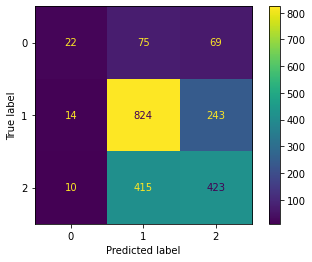

In [37]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_mnb_model_grid, X_test_app, y_test_app, 'Apple',model_name)


Confusion matrix for: Google
Model: MultinomialNB with Count Vectorize


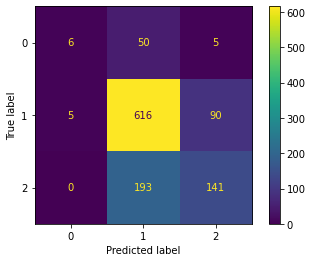

In [38]:
# Diplay confusion matrix for X_test_goo

display_confusion_matrix(cv_mnb_model_grid,X_test_goo,y_test_goo, 'Google',model_name)


In [39]:
# Use pipes to TfidfVectorize X_train_combined_processed and then train MultinomialNB()

start = time.time()

tf_mnb_pipe = Pipeline([('tfvect',TfidfVectorizer()), 
                 ('mnb', MultinomialNB())])

tf_mnb_params = {'tfvect__input' : ['content'],'mnb__alpha' : [1.0]}

tf_mnb_model_grid = GridSearchCV(estimator = tf_mnb_pipe, param_grid = tf_mnb_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


tf_mnb_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')

Training time: 0.3635385036468506


In [40]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'MultinomialNB with TF-IDF Vectorize'

display_cross_validation_results(tf_mnb_model_grid.cv_results_,model_name)

y_test_app_hat = tf_mnb_model_grid.predict(X_test_app)
y_test_goo_hat = tf_mnb_model_grid.predict(X_test_goo)

display_prediction_results(y_test_app_hat, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for MultinomialNB with TF-IDF Vectorize:
Accuracy: 0.621502650330205
Recall: 0.621502650330205 <--- Not sure!
Precision: 0.621502650330205 <--- Not sure!

Predictions for Apple: MultinomialNB with TF-IDF Vectorize
Accuracy: 0.5937947494033413
Recall: 0.5937947494033413
Precision: 0.5937947494033413

Predictions for Google: MultinomialNB with TF-IDF Vectorize
Accuracy: 0.6998191681735986
Recall: 0.6998191681735986
Precision: 0.6998191681735986



Confusion matrix for: Apple
Model: MultinomialNB with TF-IDF Vectorize


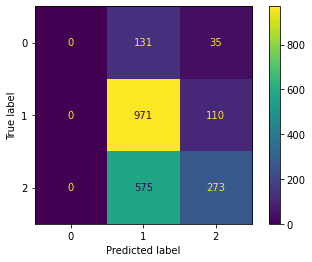

In [41]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(tf_mnb_model_grid, X_test_app, y_test_app, 'Apple',model_name)


Confusion matrix for: Google
Model: MultinomialNB with TF-IDF Vectorize


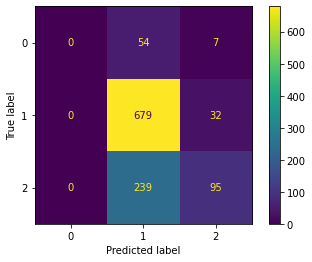

In [42]:
# Diplay confusion matrix for X_test_goo

display_confusion_matrix(tf_mnb_model_grid,X_test_goo,y_test_goo, 'Google',model_name)


In [43]:
# Use pipes to CountVectorize X_train_combined_processed and then train KNeighborsClassifier

start = time.time()

cv_knn_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('knn', KNeighborsClassifier())])

cv_knn_params = {'countvect__input' : ['content'],
                 'knn__n_neighbors' : [5,7,21],  # tried 3,7,21
                'knn__weights' : ['distance','uniform'], # tried 'uniform
                'knn__leaf_size' : [3,7,15]}  #tried 30,45

cv_knn_model_grid = GridSearchCV(estimator = cv_knn_pipe, param_grid = cv_knn_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


cv_knn_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')
cv_knn_model_grid.best_params_

Training time: 16.800080060958862


{'countvect__input': 'content',
 'knn__leaf_size': 3,
 'knn__n_neighbors': 7,
 'knn__weights': 'distance'}

In [44]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'KNeighborsClassifier with Count Vectorize'

display_cross_validation_results(cv_knn_model_grid.cv_results_,model_name)

y_test_app_hat2 = cv_knn_model_grid.predict(X_test_app)
y_test_goo_hat2 = cv_knn_model_grid.predict(X_test_goo)

display_prediction_results(y_test_app_hat2, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat2, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for KNeighborsClassifier with Count Vectorize:
Accuracy: 0.5837912756343414
Recall: 0.5837912756343414 <--- Not sure!
Precision: 0.5837912756343414 <--- Not sure!

Predictions for Apple: KNeighborsClassifier with Count Vectorize
Accuracy: 0.5608591885441527
Recall: 0.5608591885441527
Precision: 0.5608591885441527

Predictions for Google: KNeighborsClassifier with Count Vectorize
Accuracy: 0.6500904159132007
Recall: 0.6500904159132007
Precision: 0.6500904159132007



Confusion matrix for: Apple
Model: KNeighborsClassifier with Count Vectorize


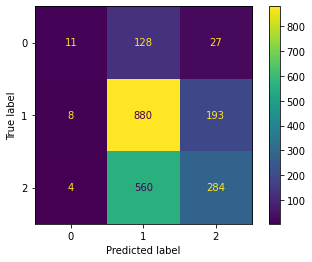

In [45]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_knn_model_grid, X_test_app, y_test_app, 'Apple',model_name)

Confusion matrix for: Google
Model: KNeighborsClassifier with Count Vectorize


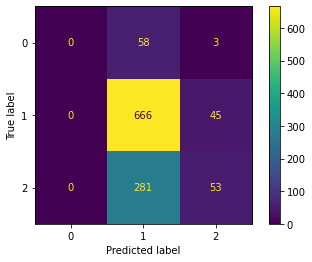

In [46]:
# Diplay confusion matrix for X_test_goo

display_confusion_matrix(cv_knn_model_grid, X_test_goo, y_test_goo, 'Google',model_name)

In [47]:
# Use pipes to TfidfVectorize X_train_combined_processed and then train KNeighborsClassifier

start = time.time()

tf_knn_pipe = Pipeline([('tfvect',TfidfVectorizer()), 
                 ('knn', KNeighborsClassifier())])

tf_knn_params = {'tfvect__input' : ['content'],
                 'knn__n_neighbors' : [5,7,21],  # tried 3,7,21
                'knn__weights' : ['distance','uniform'], # tried 'uniform
                'knn__leaf_size' : [3,7,15]}  #tried 30,45

tf_knn_model_grid = GridSearchCV(estimator = cv_knn_pipe, param_grid = cv_knn_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


tf_knn_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')
tf_knn_model_grid.best_params_

Training time: 16.458751678466797


{'countvect__input': 'content',
 'knn__leaf_size': 3,
 'knn__n_neighbors': 7,
 'knn__weights': 'distance'}

In [48]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'KNeighborsClassifier with TF-IDF Vectorize'

display_cross_validation_results(tf_knn_model_grid.cv_results_,model_name)

y_test_app_hat3 = tf_knn_model_grid.predict(X_test_app)
y_test_goo_hat3 = tf_knn_model_grid.predict(X_test_goo)

display_prediction_results(y_test_app_hat3, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat3, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for KNeighborsClassifier with TF-IDF Vectorize:
Accuracy: 0.5837912756343414
Recall: 0.5837912756343414 <--- Not sure!
Precision: 0.5837912756343414 <--- Not sure!

Predictions for Apple: KNeighborsClassifier with TF-IDF Vectorize
Accuracy: 0.5608591885441527
Recall: 0.5608591885441527
Precision: 0.5608591885441527

Predictions for Google: KNeighborsClassifier with TF-IDF Vectorize
Accuracy: 0.6500904159132007
Recall: 0.6500904159132007
Precision: 0.6500904159132007



Confusion matrix for: Apple
Model: KNeighborsClassifier with TF-IDF Vectorize


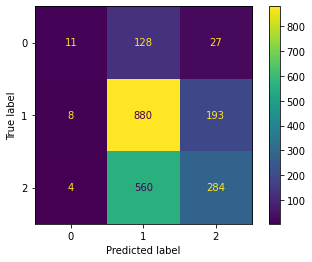

In [49]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(tf_knn_model_grid, X_test_app, y_test_app, 'Apple',model_name)

Confusion matrix for: Google
Model: KNeighborsClassifier with TF-IDF Vectorize


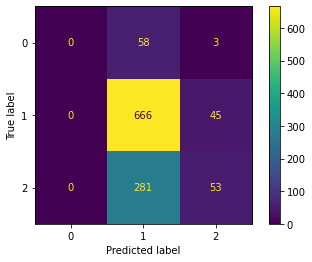

In [50]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(tf_knn_model_grid, X_test_goo, y_test_goo, 'Google',model_name)

In [ ]:
# RandomForestClassifier
# Use pipes to CountVectorize X_train_combined_processed and then train RandomForestClassifier

start = time.time()

cv_rf_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('rf', RandomForestClassifier())])

cv_rf_params = {'countvect__input' : ['content'],
                'rf__random_state' : [42],
                'rf__max_depth' : [57,87,121],  # tried 3,11
                'rf__criterion' : ['gini', 'entropy'],  #log_loss gives warning
                'rf__max_features' : ['sqrt', 'log2', None]}

cv_rf_model_grid = GridSearchCV(estimator = cv_rf_pipe, param_grid = cv_rf_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


cv_rf_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')
cv_rf_model_grid.best_params_


In [ ]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'RandomForestClassifier with Count Vectorize'

display_cross_validation_results(cv_rf_model_grid.cv_results_,model_name)

y_test_app_hat3 = tf_knn_model_grid.predict(X_test_app)
y_test_goo_hat3 = tf_knn_model_grid.predict(X_test_goo)

display_prediction_results(y_test_app_hat3, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat3, y_test_goo, 'Google',model_name)


In [ ]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_rf_model_grid, X_test_app, y_test_app, 'Apple',model_name)

In [ ]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_rf_model_grid, X_test_goo, y_test_goo, 'Google',model_name)